In [1]:
print("Last updated: $(read(`date`, String))")

Last updated: Wed Aug 12 12:22:04 PDT 2020


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [225]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using AbstractGPs, KernelFunctions
using PyPlot
using StatsFuns
using JSON3
using Flux
using ProgressBars
import Random
import LinearAlgebra

In [264]:
# For getting quantiles along array dimensions
quantiles(X, q; dims) = mapslices(x -> quantile(x, q), X, dims=dims)

# To extract parameters from ADVI model.
function make_extractor(m, q, nsamples=300)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end;

function plot_data(X, y; edgecolors=nothing)
    colors = ["blue", "red"]
    plt.scatter(X[:, 1], X[:, 2], color=colors[y .+ 1], edgecolors=edgecolors)
end;

# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end;

In [249]:
function makegrid(xmin, xmax, ymin, ymax, ngrid; return_all=false)
  ngrid = floor(Int, sqrt(ngrid))
  grid = [[i, j]
          for i in range(xmin, xmax, length=ngrid),
          j in range(ymin, ymax, length=ngrid)]
  out =  Matrix(hcat(vec(grid)...)')
    
  if return_all
    return out, grid
  else
    return out
  end
end;

In [280]:
function gp_predict(postsamps, X, y, nnew; eps=0)
    xmin = minimum(X, dims=1)
    xmax = maximum(X, dims=1)
    Xnew, grid = makegrid(xmin[1]-eps, xmax[1]+eps,
                          xmin[2]-eps, xmax[2]+eps,
                          nnew, return_all=true)
    alpha = postsamps[:alpha]
    rho = postsamps[:rho]
    sigma = postsamps[:sigma]
    nsamps = length(alpha)
    f = postsamps[:f]
        
    ps = [let
            kernel = sqexpkernel(alpha[i], rho[i])
            kernel += sigma[i]^2 * EyeKernel()
            gp = GP(kernel)
            pfx = posterior(gp(X'), f[:, i])
            logit_p = rand(pfx(Xnew'))
            logistic.(logit_p)
         end for i in ProgressBar(1:nsamps)];
    ps = hcat(ps...)
    return ps, Xnew, grid
end;

In [281]:
function plot_uq(postsamps, X, y, algo; nnew=100, eps=0.2, figsize=(10, 8),
                color_res=100, color_res_sd=100, return_stuff=false,
                data_edgecolors=nothing, vmin_sd=0, vmax_sd=nothing)
    nsamps = postsamps[:alpha]
    ps, Xnew, grid = gp_predict(postsamps, X, y, nnew, eps=eps)
    
    plt.figure(figsize=figsize)
    gs = [[g[i] for g in grid] for i in 1:2]
    
    # Plot mean function.
    plt.subplot(2, 2, 1)
    plt.contourf(gs[1], gs[2], reshape(mean(ps, dims=2), size(gs[1])...),
                 color_res, cmap=plt.get_cmap("bwr"), vmin=0, vmax=1)
    plt.colorbar();
    plot_data(X, y, edgecolors=data_edgecolors);
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ($(algo))")
    
    # Plot function sd.
    plt.subplot(2, 2, 2)
    plt.contourf(gs[1], gs[2], reshape(std(ps, dims=2), size(gs[1])...),
                 color_res_sd, cmap=plt.get_cmap("Oranges"),
                 vmin=vmin_sd, vmax=vmax_sd)
    plt.colorbar();
    plot_data(X, y)
    plt.xticks([]);
    plt.yticks([]);    
    plt.title("Posterior Standard Deviation Function ($algo)")
    
    # Plot histogram of rho.
    # plt.subplot(2, 2, 3)
    # plt.hist(post_samples['rho'], bins=30, density=True);
    # plt.title(r"Histogram of $\rho$ ({})".format(algo));
    # plt.xlabel(r"$\rho$");
    # plt.ylabel("density");
    
    # if return_stuff:
    #     return X_new, preds
end

plot_uq (generic function with 11 methods)

In [273]:
# Define a kernel.
sqexpkernel(alpha::Real, rho::Real) = 
    k = alpha^2 * transform(SqExponentialKernel(), 1/(rho*sqrt(2)))

@model function GPClassify(y, X, m_alpha=0.0, s_alpha=1.0,
                           m_rho=0.0, s_rho=1.0, m_sigma=0.0, s_sigma=1.0)
    # Priors.
    alpha ~ LogNormal(m_alpha, s_alpha)
    rho ~ LogNormal(m_rho, s_rho)
    sigma ~ LogNormal(m_sigma, s_sigma)
    
    # Realized covariance function
    kernel = sqexpkernel(alpha, rho)
    K = kernelmatrix(kernel, X, obsdim=1)
    K += sigma^2 * LinearAlgebra.I
    
    # Latent function.
    f ~ MvNormal(K)  # mean=0, covariance=K.
    
    # Sampling Distribution.
    y ~ arraydist(Bernoulli.(logistic.(f)))
end;

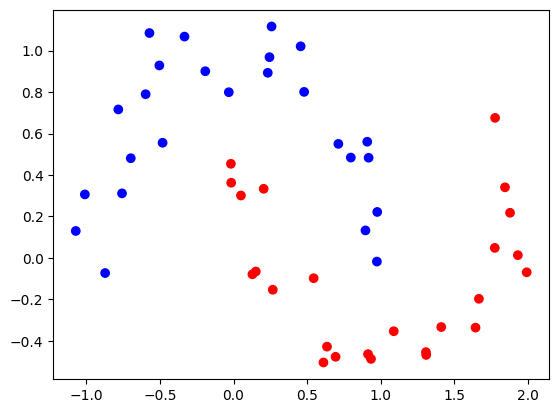

In [274]:
# Read data.

# Path to data.
data_path = joinpath(@__DIR__, "../data/gp-binary-data-N50.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), data_path)
    JSON3.read(x)
end

# Store data.
X = [data["x1"] data["x2"]]
y = Int64.(data["y"])

# Plot data.
plot_data(X, y);

In [275]:
# Create model.
m =  GPClassify(Float64.(y), X);
kernel_params = [:alpha, :rho, :sigma];

In [276]:
# Fit via ADVI.
Random.seed!(1)

# initialize variational distribution (optional)
q0 = Variational.meanfield(m)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1), q0, optimizer=Flux.ADAM(1e-1));

# RUN
@time q = vi(m, ADVI(1, 2000), q0, optimizer=Flux.ADAM(1e-1));

# Get posterior samples
extract_gp = make_extractor(m, q)
advi_samples = Dict{Symbol, Any}(sym => vec(extract_gp(sym)) for sym in kernel_params)
advi_samples[:f] = extract_gp(:f);

  4.506455 seconds (12.43 M allocations: 602.804 MiB, 2.86% gc time)


[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:01:19


 79.676067 seconds (47.65 M allocations: 81.015 GiB, 7.30% gc time)


95.7%┣█████████████████████████████████████▎ ┫ 287/300 [00:01<00:00, 191.0 it/s]

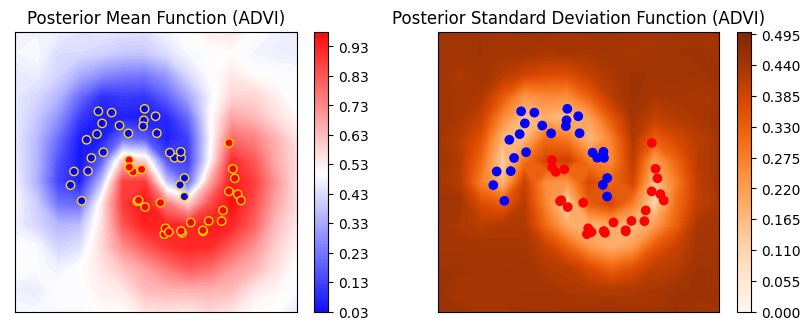

100.0%┣██████████████████████████████████████┫ 300/300 [00:02<00:00, 190.5 it/s]


In [285]:
plot_uq(advi_samples, X, y, "ADVI", eps=1,
        nnew=200, data_edgecolors="gold",
        color_res_sd=range(0, .5, length=101));